In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.axes._axes import _log as matplotlib_axes_logger
matplotlib_axes_logger.setLevel('ERROR')
from datetime import datetime
from scipy.signal import argrelextrema
pd.set_option('display.max_columns', None)

In [41]:
df = pd.read_csv("data/400+_crypto_currency_pairs/btcusd.csv")
df['datetime'] = pd.to_datetime(df['time'],unit='ms')
df.set_index('datetime',inplace=True)
df_1min = df.drop(["time"], axis=1)
df_1min.tail()

,open,close,high,low,volume
datetime,,,,,
2021-05-30 21:27:00,35981.000000,35973.000000,35996.0,35957.000000,0.440748
2021-05-30 21:28:00,35979.000000,35983.000000,35985.0,35971.000000,0.081499
2021-05-30 21:29:00,35961.000000,35949.821007,35961.0,35949.821007,0.010000
2021-05-30 21:30:00,35947.628977,35974.000000,35975.0,35911.000000,0.132703
2021-05-30 21:31:00,35974.215267,35992.000000,35992.0,35974.215267,0.724348


In [42]:
idx = pd.date_range('2013-04-01 00:07:00', '2021-05-30 21:31:00', freq='1Min')
df_1min.index = pd.DatetimeIndex(df_1min.index)
df_1min = df_1min.reindex(idx, fill_value='NaN')
df_1min.loc[df_1min.open == "NaN"] = np.nan
df_1min = df_1min.fillna(method='ffill')
df_1min["volume_usd"] = (df_1min["open"]+df_1min["close"]+df_1min["high"]+df_1min["low"])/4*df_1min["volume"]
df_1min.head()

,open,close,high,low,volume,volume_usd
2013-04-01 00:07:00,93.25,93.30,93.30,93.25,93.300000,8702.55750
2013-04-01 00:08:00,100.00,100.00,100.00,100.00,93.300000,9330.00000
2013-04-01 00:09:00,93.30,93.30,93.30,93.30,33.676862,3142.05125
2013-04-01 00:10:00,93.30,93.30,93.30,93.30,33.676862,3142.05125
2013-04-01 00:11:00,93.35,93.47,93.47,93.35,20.000000,1868.20000


In [43]:
df_15min = df_1min.groupby(pd.Grouper(freq='15Min')).agg({"open": "first", 
                                                        "close": "last", 
                                                        "low": "min", 
                                                        "high": "max",
                                                         "volume": "sum",
                                                         "volume_usd": "sum"})
df_15min.columns = ["open", "close", "low", "high", "vol_btc", "vol_usd"]
df = df_15min.copy()

In [44]:
df["avrg_ohlc"] = (df["open"] + df["high"] + df["close"] + df["low"]) / 4
df["avrg_hlc"] = (df["close"] + df["low"] + df["high"]) / 3
df["avrg_hl"] = (df["high"] + df["low"]) / 2
df_perc = df.pct_change()*100
df = pd.merge(left=df, right=df_perc, left_index=True, right_index=True)
df = df.rename(columns = {"open_x":"open_price",
                          "close_x":"close_price", 
                          "high_x":"high_price", 
                          "low_x":"low_price", 
                          "vol_btc_x":"vol_btc_qt", 
                          "vol_usd_x":"vol_usd_qt", 
                          "avrg_ohlc_x":"avrg_ohlc_price", 
                          "avrg_hlc_x":"avrg_hlc_price", 
                          "avrg_hl_x":"avrg_hl_price", 
                          
                          "open_y":"open_perc",
                          "close_y":"close_perc",
                          "high_y":"high_perc", 
                          "low_y":"low_perc",
                          "vol_btc_y":"vol_btc_perc", 
                          "vol_usd_y":"vol_usd_perc", 
                          "avrg_ohlc_y":"avrg_ohlc_perc",
                          "avrg_hlc_y":"avrg_hlc_perc", 
                          "avrg_hl_y":"avrg_hl_perc"})

In [45]:
#one hour volatility
one_hour = 4 # 4 15 minute periods in 1 hour
df['stdev_1h'] = df['avrg_hl_perc'].rolling(one_hour).std(ddof=0)
#four hour volatility
four_hour = 16 # 16 15 minute periods in 4 hours
df['stdev_4h'] = df['avrg_hl_perc'].rolling(four_hour).std(ddof=0)
#twelve hour volatilityy
twelve_hours = 48 # 48 15 minute periods in 12 hours
df['stdev_12h'] = df['avrg_hl_perc'].rolling(twelve_hours).std(ddof=0)
#daily volatility
one_day = 96 # 96 15 minute periods in 1 days
df['stdev_1d'] = df['avrg_hl_perc'].rolling(one_day).std(ddof=0)
#one week volatility
one_week = 672 # 672 15 minute periods in 7 days
df['stdev_1w'] = df['avrg_hl_perc'].rolling(one_week).std(ddof=0)
#one week volatility
two_weeks = 1344 # 1344 15 minute periods in 14 days
df['stdev_2w'] = df['avrg_hl_perc'].rolling(two_weeks).std(ddof=0)

<AxesSubplot:>

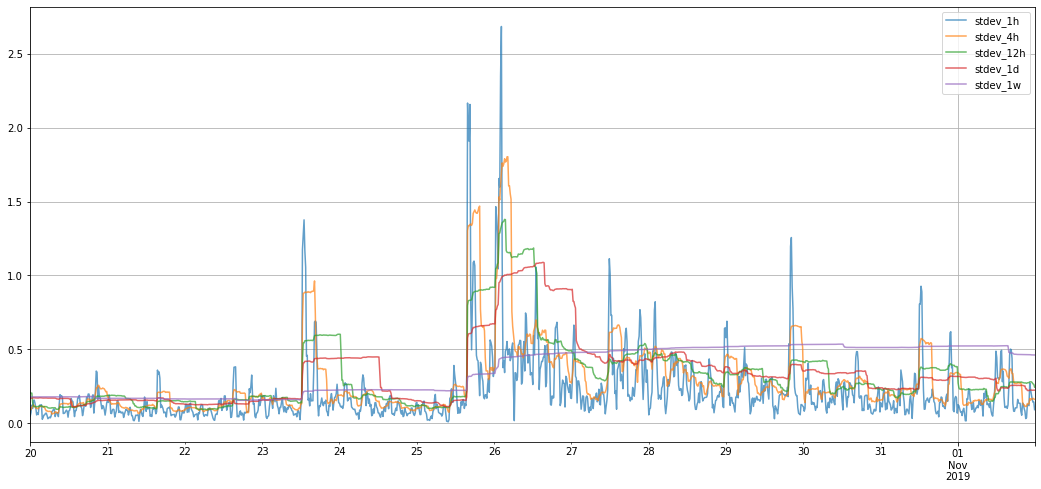

In [47]:
df.iloc[:,-6:-1]["2019-10-20":"2019-11-01"].plot(figsize=(18,8), alpha=0.7, grid=True)